# Ranking heuristics & Graph-Based signals: Experiments and Evaluation

This notebook implements and evaluates ranking heuristics and graph based signals.
For ranking heuristics mix of popularity and recency based ranking was used: final score is the number of book occurences in train set, weighted with time decay factor $2^{-\Delta t / h}$, where $h$ is half-life factor and equals 30 days. This way we penalize older ratings and assign more relevance to newer ones.

For graph-based approach we calculate edges between books as number of times two books were rated by the same user with cosine normalization, to compensate for popularity factor.

In [130]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.data.loader import load_all_data
from src.data.splitter import create_temporal_split, SplitConfig, add_random_timestamps, UserTemporalSplitConfig
from src.evaluation import (
    EvaluationPipeline,
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Data Loading and Temporal Split

For this task temporal split we use differs from similarity recommendation algorithms. If we split by the year the book was published, matrix factorization inherently make no sense, as all of the validation and test books will face cold start problem. Therefore we create random variable timestamp, that simulates time the book was rated. Then, for each user we order ratings by timestamp and split train/val/test with 0.7/0.15/0.15 ratio, so that older books go in train and newer into validation and test. This creates simulation of temporal data.

In [222]:
# Load data
ratings, books, users = load_all_data('../data/raw')

ratings_ts = add_random_timestamps(ratings, start="2004-08-01", end="2004-09-30", seed=123, ts_col="timestamp")



In [223]:
import re
import pandas as pd

# -----------------------
# 1) Canonicalizers (string-level)
# -----------------------
def canon_text(s: str) -> str:
    if s is None or (isinstance(s, float) and pd.isna(s)) or pd.isna(s):
        return ""
    s = str(s).lower()

    # remove edition/format noise in (...) or [...]
    s = re.sub(r"\([^)]*\)", " ", s)
    s = re.sub(r"\[[^\]]*\]", " ", s)

    # remove punctuation
    s = re.sub(r"[^a-z0-9\s]+", " ", s)

    # collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s


# -----------------------
# 2) Build canonical ISBN mapping using only (title, author)
# -----------------------
def build_canonical_isbn_map(books: pd.DataFrame) -> pd.DataFrame:
    """
    books columns: isbn, title, author, year, publisher (year/publisher ignored)
    returns mapping with:
      original_isbn, isbn(new canonical), canon_title, canon_author, canon_key
    """
    b = books.copy().rename(columns={"isbn": "original_isbn"})

    b["canon_title"] = b["title"].map(canon_text)
    b["canon_author"] = b["author"].map(canon_text)

    # canonical key: only title + author
    b["canon_key"] = b["canon_title"] + "||" + b["canon_author"]

    # create stable integer ids per canonical key
    codes, uniques = pd.factorize(b["canon_key"], sort=True)
    b["isbn"] = (codes + 1).astype("int64")  # new canonical "isbn"

    # keep one row per original isbn (in case of duplicates)
    mapping = b[["original_isbn", "isbn", "canon_title", "canon_author", "canon_key"]].drop_duplicates("original_isbn")
    return mapping


# -----------------------
# 3) Apply mapping to ratings and rename columns
# -----------------------
def merge_canonical_isbn_to_ratings(
    ratings: pd.DataFrame,
    mapping: pd.DataFrame,
    ratings_isbn_col: str = "isbn",
) -> pd.DataFrame:
    """
    ratings columns: userId, isbn, rating, timestamp (or similar)
    mapping: output of build_canonical_isbn_map
    Output:
      - ratings has original isbn preserved as 'original_isbn'
      - ratings has new canonical isbn in column 'isbn'
    """
    r = ratings.copy().rename(columns={ratings_isbn_col: "original_isbn"})

    r = r.merge(mapping[["original_isbn", "isbn"]], on="original_isbn", how="left")

    # optional: if some ISBNs in ratings are missing from books/mapping
    # keep them as their own canonical ids (or drop)
    missing = r["isbn"].isna()
    if missing.any():
        # assign new ids after existing max
        start = int(mapping["isbn"].max()) + 1 if len(mapping) else 1
        r.loc[missing, "isbn"] = range(start, start + missing.sum())
    r["isbn"] = r["isbn"].astype("int64")

    return r


# -----------------------
# Example usage
# -----------------------
# books_df: columns [isbn, title, author, year, publisher]
# ratings_df: columns [userId, isbn, rating, timestamp]

mapping_df = build_canonical_isbn_map(books)
ratings_canon = merge_canonical_isbn_to_ratings(ratings_ts, mapping_df)

# Now:
# - books_df still unchanged
# - mapping_df has original_isbn -> new isbn
# - ratings_canon has columns: original_isbn (old), isbn (new), plus userId/rating/timestamp


def add_canonical_isbn_to_books(books_df: pd.DataFrame) -> pd.DataFrame:
    """
    Input columns: isbn, title, author, year, publisher
    Output: same df but
      - old 'isbn' renamed to 'original_isbn'
      - new integer 'isbn' created from canonicalized (title, author)
    """
    b = books_df.copy()

    # rename old isbn
    b = b.rename(columns={"isbn": "original_isbn"})

    # canonical key from title + author only
    canon_title = b["title"].map(canon_text)
    canon_author = b["author"].map(canon_text)
    canon_key = canon_title + "||" + canon_author

    # stable integer ids per canonical key
    codes, _ = pd.factorize(canon_key, sort=True)
    b["isbn"] = (codes + 1).astype("int64")   # new canonical "isbn"

    return b

# usage:
books = add_canonical_isbn_to_books(books)

In [224]:
books

,original_isbn,title,author,year,publisher,isbn
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,35126
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,34965
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,46161
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,66844
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton & Company,195471
...,...,...,...,...,...,...
271005,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988.0,Random House Childrens Pub (Mm),212054
271006,0525447644,From One to One Hundred,Teri Sloat,1991.0,Dutton Books,69851
271007,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004.0,HarperSanFrancisco,106264
271008,0192126040,Republic (World's Classics),Plato,1996.0,Oxford University Press,146204


In [225]:
K_VALUES = [10]

In [226]:
mapping_df[mapping_df['canon_title'] == 'harry potter and the chamber of secrets']

,original_isbn,isbn,canon_title,canon_author,canon_key
3459,0439064872,78630,harry potter and the chamber of secrets,j k rowling,harry potter and the chamber of secrets||j k r...
5432,0439064864,78630,harry potter and the chamber of secrets,j k rowling,harry potter and the chamber of secrets||j k r...
10441,0439420105,78630,harry potter and the chamber of secrets,j k rowling,harry potter and the chamber of secrets||j k r...
28427,0807281948,78630,harry potter and the chamber of secrets,j k rowling,harry potter and the chamber of secrets||j k r...
34084,0747545774,78630,harry potter and the chamber of secrets,j k rowling,harry potter and the chamber of secrets||j k r...
52578,0807281913,78630,harry potter and the chamber of secrets,j k rowling,harry potter and the chamber of secrets||j k r...
60259,1551922444,78630,harry potter and the chamber of secrets,j k rowling,harry potter and the chamber of secrets||j k r...
72188,0439554896,78630,harry potter and the chamber of secrets,j k rowling,harry potter and the chamber of secrets||j k r...
140394,0786222735,78630,harry potter and the chamber of secrets,j k rowling,harry potter and the chamber of secrets||j k r...


In [231]:
ratings_ts[ratings_ts['isbn'] == 78630]

,user_id,original_isbn,rating,timestamp,isbn
534,276929,0439064864,0,2004-09-07 07:31:39.041202854,78630
1629,277427,0439064872,0,2004-08-12 14:21:00.709741968,78630
4257,278356,0439064872,8,2004-08-25 17:09:23.363378191,78630
10208,254,0439064864,9,2004-08-12 23:28:49.377616140,78630
10209,254,0439064872,9,2004-09-14 19:02:16.167347933,78630
...,...,...,...,...,...
1144459,275210,0439064872,0,2004-08-08 23:03:32.567387329,78630
1145142,275401,0439064864,9,2004-08-08 17:24:28.300026573,78630
1146811,275970,0439420105,9,2004-09-04 17:28:11.784311442,78630
1147323,275970,0807281948,0,2004-09-22 02:04:17.235080678,78630


In [228]:
books[books['isbn'] == 78630]

,original_isbn,title,author,year,publisher,isbn
3459,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000.0,Scholastic,78630
5432,0439064864,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999.0,Scholastic,78630
10441,0439420105,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2002.0,Scholastic,78630
28427,0807281948,Harry Potter and the Chamber of Secrets (Book ...,J. K. Rowling,1999.0,Listening Library,78630
34084,0747545774,Harry Potter and the Chamber of Secrets,J. K. Rowling,2000.0,Trafalgar Square (J),78630
52578,0807281913,Harry Potter and the Chamber of Secrets (Book ...,J. K. Rowling,1999.0,Listening Library,78630
60259,1551922444,Harry Potter and the Chamber of Secrets,J. K. Rowling,2000.0,Raincoast Book Distribution,78630
72188,0439554896,Harry Potter and the Chamber of Secrets (Harry...,J. K. Rowling,2003.0,Arthur A. Levine Books,78630
140394,0786222735,Harry Potter and the Chamber of Secrets (Thorn...,J. K. Rowling,2000.0,Thorndike Press,78630


In [250]:
ratings_ts = ratings_canon
ratings_ts['isbn'] = ratings_canon['isbn'].astype('string')
books['isbn'] = books['isbn'].astype('string')
mapping_df['isbn'] = mapping_df['isbn'].astype('string')

## 2. Popularity/recency-based ranking
### 2.1 relevance_threshold = 6

In [234]:
# Create temporal split
config = UserTemporalSplitConfig(
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    min_train=1,
    min_val=1,
    min_test=1,
    min_user_interactions = 10,
    min_item_interactions = 10,
    explicit_only = True
)


train_df, val_df, test_df, split_info = create_temporal_split(ratings_ts, books, "users", config)
test_df = pd.concat([test_df, val_df], axis=0, ignore_index=True)


--- Step 1: Filtering data ---
Original ratings: 1,149,780
After explicit filter: 433,671 ratings
After year filter (1900-2004): 926,140 ratings
Iteration 1: 586,031 ratings, 14,951 users, 7,988 items
Iteration 2: 567,215 ratings, 12,562 users, 7,596 items
Iteration 3: 566,560 ratings, 12,500 users, 7,577 items
Iteration 4: 566,534 ratings, 12,498 users, 7,576 items
Iteration 5: 566,517 ratings, 12,497 users, 7,575 items
Iteration 6: 566,517 ratings, 12,497 users, 7,575 items

--- Step 2: Temporal split ---
Initial split sizes (by user timestamp):
  Train: 391,144 ratings
  Val: 78,646 ratings
  Test: 96,727 ratings

--- Step 3: Ensuring test users have training history ---

--- Final Split Summary ---
Set             Ratings      Users      Items           Years   Avg Rating
----------------------------------------------------------------------
train           391,144     12,497      7,559       1904-2004         7.95
val              78,646     12,497      6,044       1904-2004     

In [235]:
ratings_ts[(ratings_ts['user_id'] == '31466') & (ratings_ts['rating'] > 0)]

,user_id,original_isbn,rating,timestamp,isbn
139288,31466,0310214696,10,2004-08-29 15:57:37.044737923,251622
139301,31466,0345361083,10,2004-09-07 17:26:47.708407241,195155
139304,31466,0345439112,8,2004-08-07 12:57:42.107100294,10553
139307,31466,0345455304,10,2004-09-27 21:11:47.532140319,89263
139311,31466,0373872127,8,2004-08-08 14:39:21.314642766,179599
139338,31466,051512558X,10,2004-08-20 05:23:40.137166363,197822
139351,31466,067946316X,10,2004-08-24 13:16:21.048221939,112383
139355,31466,0743227549,10,2004-09-18 12:51:34.441576317,233202
139356,31466,0743236742,10,2004-08-13 13:38:28.836179292,208231
139380,31466,0804119740,10,2004-09-04 13:58:09.359363106,100978


In [236]:
train_df[(train_df['user_id'] == '31466')]

,user_id,original_isbn,rating,timestamp,isbn,year


In [237]:
train_items = set(train_df['isbn'].unique())
test_items = set(test_df['isbn'].unique())
overlap = train_items & test_items

print("TEMPORAL SPLIT")
print("=" * 50)
print(f"Train items: {len(train_items):,}")
print(f"Test items: {len(test_items):,}")
print(f"Overlap (items in both): {len(overlap)}")

# Shared users
train_users = set(train_df['user_id'].unique())
test_users = set(test_df['user_id'].unique())
shared_users = train_users & test_users
print(f"\nShared users (in both train and test): {len(shared_users):,}")
print(f"Test-only users: {len(test_users - train_users):,}")

TEMPORAL SPLIT
Train items: 7,559
Test items: 7,223
Overlap (items in both): 7207

Shared users (in both train and test): 12,497
Test-only users: 0


In [238]:
from datetime import datetime
today = datetime.strptime('2004-09-30 00:12:53', "%Y-%m-%d %H:%M:%S")


In [239]:
h = 30
train_df['implicit_style'] = np.where(train_df['rating'] != 0, 1, 0)
train_df['delta_t'] = (today - train_df['timestamp']).dt.total_seconds()/(3600*24)
train_df['decay'] = 2**(-train_df['delta_t']/h)
train_df['score'] = train_df['decay']*train_df['implicit_style']
occurences = train_df[['isbn', 'implicit_style']].groupby(['isbn']).sum('implicit_style').reset_index()
items_scores_grouped = train_df[['isbn', 'score']].groupby(['isbn']).sum('score').sort_values(by = 'score', ascending = False).reset_index()
items_scores_grouped = items_scores_grouped.merge(occurences, how = 'left', on = 'isbn')


In [240]:
items_scores_grouped

,isbn,score,implicit_style
0,140690,3368.364192,6926
1,233505,3252.440006,6634
2,93749,2811.731080,5912
3,53773,2194.370240,4615
4,78638,2175.248716,4614
...,...,...,...
7554,164772,0.578428,2
7555,58147,0.574845,2
7556,180943,0.568516,2
7557,68977,0.512239,2


In [243]:
books[books['isbn'] == '140690']

,original_isbn,title,author,year,publisher,isbn
41,055321215X,Pride and Prejudice,Jane Austen,1983.0,Bantam,140690
167,0486284735,Pride and Prejudice (Dover Thrift Editions),Jane Austen,1995.0,Dover Publications,140690
3800,0460872125,Pride and Prejudice (Everyman Paperback Classics),Jane Austen,1993.0,J.M. Dent & Sons,140690
6745,0553213105,Pride and Prejudice,Jane Austen,1981.0,Bantam,140690
7846,0140373373,Pride and Prejudice (Puffin Classics),Jane Austen,1995.0,Puffin Books,140690
7879,0140430725,Pride and Prejudice (The Penguin English Libra...,Jane Austen,1985.0,Penguin Books,140690
8404,0679783261,Pride and Prejudice (Modern Library Classics),Jane Austen,2000.0,Modern Library,140690
13197,0451523652,Pride and Prejudice,Jane Austen,1988.0,New Amer Library Classics,140690
16831,1566190932,Pride and Prejudice,Jane Austen,1993.0,Barnes Noble Classics,140690
18485,0451525884,Pride and Prejudice,Jane Austen,1996.0,Signet Book,140690


In [244]:
# Evaluate popularity/recency-based methods - Ranking
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=6)

all_results = {}
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
heuristics_ranking = pipeline.evaluate_ranking_heuristic(items_scores_grouped['isbn'], test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {heuristics_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {heuristics_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {heuristics_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {heuristics_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

# Merge results
all_results['Heuristics_min6'] = heuristics_ranking

Evaluating ranking (this may take a few minutes)...
test_df len 12497
6
user_relevant len 11792
11792
  NDCG@10:     0.0026
  Precision@10: 0.0019
  Hit Rate@10:  0.0164
  Users eval'd: 11792
  Time: 18.2s


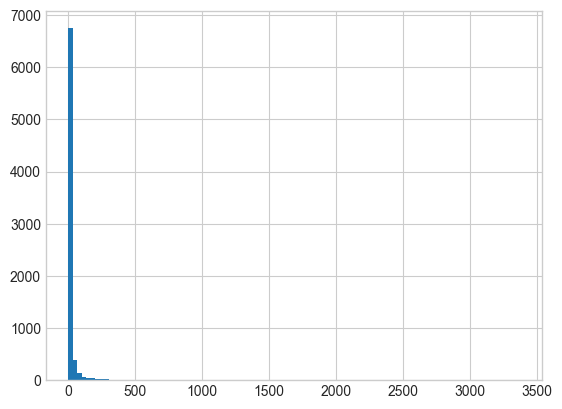

In [245]:
plt.hist(items_scores_grouped['score'], bins = 100)
plt.show()

In [254]:
items_scores_grouped.head(5).merge(mapping_df[['isbn', 'canon_title', 'canon_author']].drop_duplicates())

,isbn,score,implicit_style,canon_title,canon_author
0,140690,3368.364192,6926,pride and prejudice,jane austen
1,233505,3252.440006,6634,wuthering heights,emily bronte
2,93749,2811.731080,5912,jane eyre,charlotte bronte
3,53773,2194.370240,4615,dracula,bram stoker
4,78638,2175.248716,4614,harry potter and the sorcerer s stone,j k rowling


### 2.2 relevance_threshold = 1

In [255]:
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=1)
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
heuristics_ranking = pipeline.evaluate_ranking_heuristic(items_scores_grouped['isbn'], test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {heuristics_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {heuristics_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {heuristics_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {heuristics_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

all_results['Heuristics_min1'] = heuristics_ranking

Evaluating ranking (this may take a few minutes)...
test_df len 12497
1
user_relevant len 12497
12497
  NDCG@10:     0.0024
  Precision@10: 0.0018
  Hit Rate@10:  0.0160
  Users eval'd: 12497
  Time: 19.6s


## 3. Graph based approach
### 3.1 relevance_threshold = 6

In [256]:
from collections import Counter, defaultdict
from itertools import combinations
from math import sqrt


user_items = train_df.groupby("user_id")["isbn"].apply(lambda x: pd.unique(x).tolist())

pair_cnt = Counter()
item_cnt = Counter()

for items in user_items:
    for i in items:
        item_cnt[i] += 1
    for i, j in combinations(sorted(items), 2):
        pair_cnt[(i, j)] += 1

neighbors = defaultdict(list)  

for (i, j), cij in pair_cnt.items():
    sim = cij / sqrt(item_cnt[i] * item_cnt[j])
    neighbors[i].append((j, sim))
    neighbors[j].append((i, sim))

M = 200 

for i in list(neighbors.keys()):
    neighbors[i].sort(key=lambda x: x[1], reverse=True)
    neighbors[i] = neighbors[i][:M]

In [260]:
for (i, j), cij in pair_cnt.most_common(10):
    print(mapping_df[mapping_df['isbn'] == i]['canon_title'].drop_duplicates().item(), '\t', mapping_df[mapping_df['isbn'] == j]['canon_title'].drop_duplicates().item(), '\t', cij)

harry potter and the chamber of secrets 	 harry potter and the sorcerer s stone 	 104
harry potter and the chamber of secrets 	 harry potter and the prisoner of azkaban 	 96
harry potter and the prisoner of azkaban 	 harry potter and the sorcerer s stone 	 84
harry potter and the goblet of fire 	 harry potter and the prisoner of azkaban 	 83
harry potter and the chamber of secrets 	 harry potter and the goblet of fire 	 79
harry potter and the goblet of fire 	 harry potter and the sorcerer s stone 	 69
the fellowship of the ring 	 the two towers 	 54
the return of the king 	 the two towers 	 51
harry potter and the order of the phoenix 	 harry potter and the prisoner of azkaban 	 47
harry potter and the goblet of fire 	 harry potter and the order of the phoenix 	 43


In [261]:
user_hist = train_df.groupby("user_id").apply(
    lambda g: list(zip(g["isbn"].values, g["rating"].values, g["timestamp"].values))
)
user_seen = train_df.groupby("user_id")["isbn"].apply(set)

def recommend_user(u, K=10):
    hist = user_hist.get(u, [])
    seen = user_seen.get(u, set())

    scores = Counter()

    for item_j, r, ts in hist:
        for item_i, sim in neighbors.get(item_j, []):
            if item_i not in seen:
                scores[item_i] += sim

    return [i for i, s in scores.most_common(K)]

recommendations_dict = {}
for user_id in test_df['user_id'].drop_duplicates():
    recommendations_dict[user_id] = recommend_user(user_id, 10)

/var/folders/0l/fh4k0dv16bd0jg5rbzdk8c000000gp/T/ipykernel_4223/3252019286.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_hist = train_df.groupby("user_id").apply(


In [262]:
# Evaluate Graph-based - Ranking
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=6)

print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
graph_ranking = pipeline.evaluate_ranking_graph(recommendations_dict, test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {graph_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {graph_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {graph_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {graph_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

all_results['Graph_min6'] = graph_ranking

Evaluating ranking (this may take a few minutes)...
test_df len 12497
6
user_relevant len 11792
11792
  NDCG@10:     0.0215
  Precision@10: 0.0086
  Hit Rate@10:  0.0623
  Users eval'd: 11792
  Time: 0.6s


### 3.2 relevance_threshold = 1

In [263]:
# Evaluate Graph-based - Ranking
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=1)

print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
graph_ranking = pipeline.evaluate_ranking_graph(recommendations_dict, test_df, train_df, n_recommendations=10)
print(f"  NDCG@10:     {graph_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {graph_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {graph_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {graph_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")

all_results['Graph_min1'] = graph_ranking

Evaluating ranking (this may take a few minutes)...
test_df len 12497
1
user_relevant len 12497
12497
  NDCG@10:     0.0207
  Precision@10: 0.0087
  Hit Rate@10:  0.0627
  Users eval'd: 12497
  Time: 0.7s


## 4. Results comparison

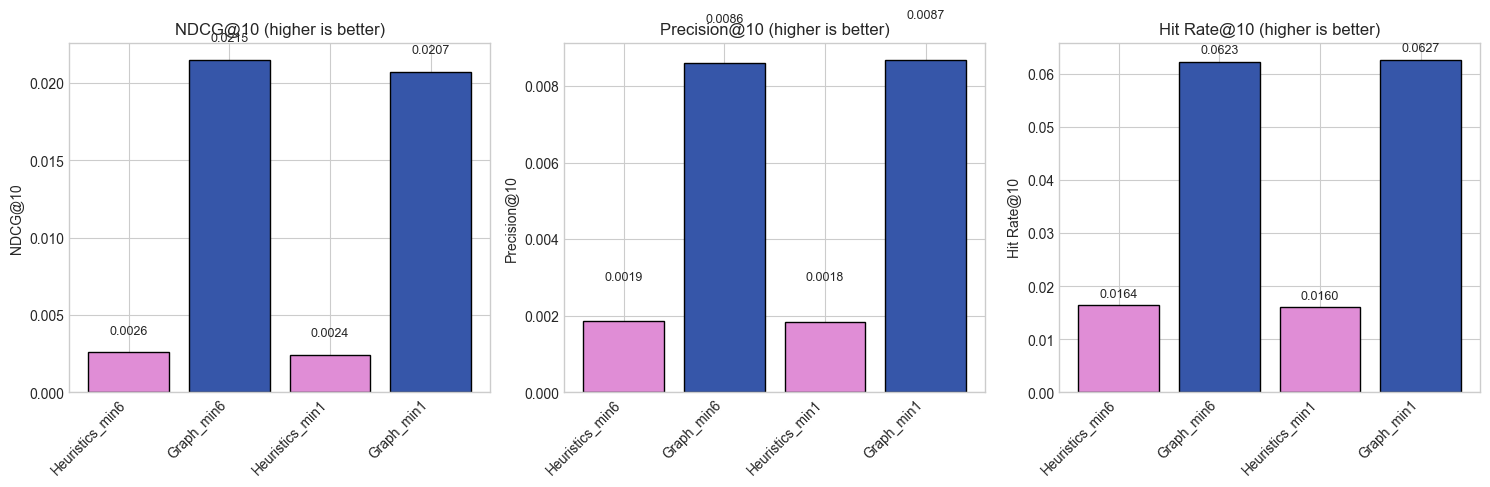

In [264]:
# Visualize ranking metrics (only models that have ranking results)
model_order = ['Heuristics_min6', 'Graph_min6', 'Heuristics_min1', 'Graph_min1']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
ranking_colors = []
for m in model_order:
    if 'Heuristics' in m:
        ranking_colors.append("#e08dd6")
    elif 'Graph' in m:
        ranking_colors.append("#3656A9")


for idx, (metric, title) in enumerate([
    ('ndcg@10', 'NDCG@10'),
    ('precision@10', 'Precision@10'),
    ('hit_rate@10', 'Hit Rate@10')
]):
    ax = axes[idx]
    vals = [all_results[m].get(metric, 0) for m in model_order]
    bars = ax.bar(range(len(model_order)), vals, color=ranking_colors, edgecolor='black')
    ax.set_xticks(range(len(model_order)))
    ax.set_xticklabels(model_order, rotation=45, ha='right')
    ax.set_ylabel(title)
    ax.set_title(f'{title} (higher is better)')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../experiments/similarity_ranking_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


In [214]:
import re

def canonicalize_title_str(title: str) -> str:
    if title is None:
        return ""
    s = title.lower()

    # remove anything in (...) or [...] (often edition/format noise)
    s = re.sub(r"\([^)]*\)", " ", s)
    s = re.sub(r"\[[^\]]*\]", " ", s)

    # remove punctuation (keep letters/numbers/spaces)
    s = re.sub(r"[^a-z0-9\s]+", " ", s)

    # collapse whitespace
    s = re.sub(r"\s+", " ", s).strip()
    return s

for i in books.itertuples(index=False):
    if 'Chamber of Secrets' in i.title:
        print(i.title)
        print(ratings_ts[ratings_ts['isbn'] == i.isbn].shape)
        print(i.author)
        print(canonicalize_title_str(i.title))

Harry Potter and the Chamber of Secrets (Book 2)
(351, 4)
J. K. Rowling
harry potter and the chamber of secrets
Harry Potter and the Chamber of Secrets (Book 2)
(170, 4)
J. K. Rowling
harry potter and the chamber of secrets
Harry Potter and the Chamber of Secrets (Book 2)
(35, 4)
J. K. Rowling
harry potter and the chamber of secrets
Harry Potter and the Chamber of Secrets (Book 2 Audio CD)
(7, 4)
J. K. Rowling
harry potter and the chamber of secrets
Harry Potter and the Chamber of Secrets
(2, 4)
J. K. Rowling
harry potter and the chamber of secrets
Harry Potter and the Chamber of Secrets (Book 2, Audio)
(2, 4)
J. K. Rowling
harry potter and the chamber of secrets
Harry Potter and the Chamber of Secrets
(3, 4)
J. K. Rowling
harry potter and the chamber of secrets
Harry Potter and the Chamber of Secrets (Harry Potter)
(3, 4)
J. K. Rowling
harry potter and the chamber of secrets
Harry Potter and the Chamber of Secrets Postcard Book
(40, 4)
J. K. Rowling
harry potter and the chamber of sec

In [185]:
books[books['title'] == 'Harry Potter and the Chamber of Secrets Postcard Book']

,isbn,title,author,year,publisher
79372,0439425220,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,2002.0,Scholastic


In [208]:
train_df[train_df['isbn'] == '0439064864']

,user_id,isbn,rating,timestamp,year
2284,254,0439064864,9,2004-08-12 23:28:49.377616140,1999.0
4076,2033,0439064864,9,2004-08-22 07:29:58.030642447,1999.0
7269,4809,0439064864,7,2004-08-22 14:37:58.430780064,1999.0
12238,8529,0439064864,10,2004-08-13 10:25:23.244384753,1999.0
17701,11676,0439064864,10,2004-08-13 14:54:06.524042600,1999.0
...,...,...,...,...,...
357113,254859,0439064864,10,2004-08-06 15:26:05.859965954,1999.0
362989,259660,0439064864,7,2004-08-15 04:19:03.054118919,1999.0
373908,268657,0439064864,6,2004-08-20 07:33:07.848424235,1999.0
382245,275401,0439064864,9,2004-08-08 17:24:28.300026573,1999.0


In [153]:
ratings_ts[ratings_ts['isbn'] == '1551922444']

,user_id,isbn,rating,timestamp
139420,31466,1551922444,0,2004-09-26 07:10:54.951167245
365021,87712,1551922444,10,2004-08-04 20:03:26.712210816
742810,179739,1551922444,0,2004-09-10 03:00:03.612458882


In [158]:
ratings_ts[(ratings_ts['user_id'] == '31466') & (ratings_ts['rating'] >0)]

,user_id,isbn,rating,timestamp
139288,31466,0310214696,10,2004-08-29 15:57:37.044737923
139301,31466,0345361083,10,2004-09-07 17:26:47.708407241
139304,31466,0345439112,8,2004-08-07 12:57:42.107100294
139307,31466,0345455304,10,2004-09-27 21:11:47.532140319
139311,31466,0373872127,8,2004-08-08 14:39:21.314642766
139338,31466,051512558X,10,2004-08-20 05:23:40.137166363
139351,31466,067946316X,10,2004-08-24 13:16:21.048221939
139355,31466,0743227549,10,2004-09-18 12:51:34.441576317
139356,31466,0743236742,10,2004-08-13 13:38:28.836179292
139380,31466,0804119740,10,2004-09-04 13:58:09.359363106


In [159]:
train_df[(train_df['user_id'] == '31466')]

,user_id,isbn,rating,timestamp,year,implicit_style,delta_t,decay,score
